In [ ]:
# Mount Google Drive untuk mengakses file
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


Local Inference on GPU Model page: https://huggingface.co/indobenchmark/indobert-base-p1

⚠️ If the generated code snippets do not work, please open an issue on either the model repo and/or on huggingface.js 🙏

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
!sed -i 's/\\\//\//g' /usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py


# Fine Tuning Indobert Hasil Pelabelan Otomatis Data Primer + Word2vec + Cosine Similarity

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Word2vec/Dataset Labelled/Data Primer_Word2vec_Cosine Similarity/data_postingan_labeled.csv')
df.head(5)

,full_text,similarity_score,referensi_terdekat,label
0,Ini jadi bukti klaim2 gerakan dakwah ajaran ag...,0.878719,"Aktivitas Intoleransi, Radikalisme, dan Terori...",Radikal
1,@bossnya 5. Dakwah menyadarkan agar qt kembali...,0.847079,"Aktivitas Intoleransi, Radikalisme, dan Terori...",Radikal
2,@bnsphrxyzzz @mx00711 @agama_nusantara @sakkus...,0.782480,"Aktivitas intoleransi, radikalisme, dan terori...",Radikal
3,@Tita83079013 @MUIPusat @Kemenag_RI ISLAM ITU ...,0.786935,"Motif ideologi, politik, atau gangguan keamanan.",Radikal
4,Tradisi menarik lahir setelahnya: setiap Sulta...,0.738889,"Aktivitas intoleransi, radikalisme, dan terori...",Radikal


In [ ]:
df.label.value_counts()

,count
label,
Radikal,1018
Non-Radikal,468


Map:   0%|          | 0/1188 [00:00<?, ? examples/s]

Map:   0%|          | 0/298 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samshidayaturrohman (samshidayaturrohman-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.667800,0.441315,0.808725,0.843898,0.808725,0.780536
2,0.387700,0.287935,0.879195,0.879195,0.879195,0.879195
3,0.218000,0.337686,0.882550,0.889300,0.882550,0.876347


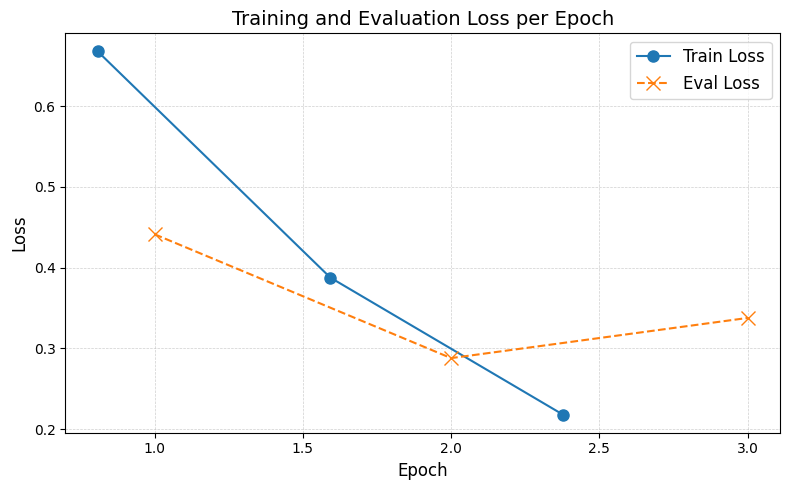

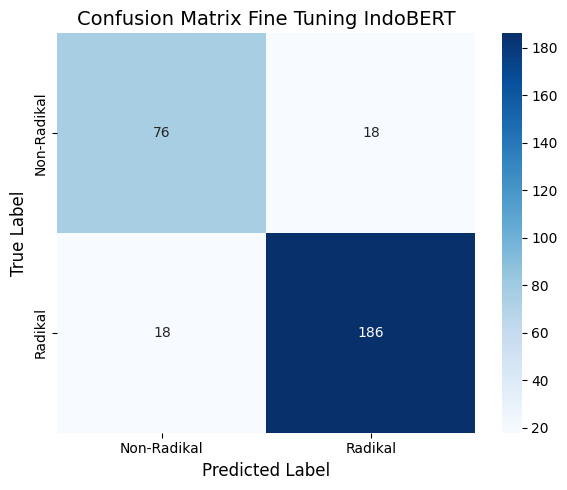

              precision    recall  f1-score   support

 Non-Radikal       0.81      0.81      0.81        94
     Radikal       0.91      0.91      0.91       204

    accuracy                           0.88       298
   macro avg       0.86      0.86      0.86       298
weighted avg       0.88      0.88      0.88       298



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch

# 1. Memuat dan mempersiapkan dataset
df = pd.read_csv('/content/drive/MyDrive/Word2vec/Dataset Labelled/Data Primer_Word2vec_Cosine Similarity/data_postingan_labeled.csv')
X = df['full_text'].tolist()
y_string_labels = df['label'].tolist()
label_map = {0: "Non-Radikal", 1: "Radikal"}
string_label_to_id = {v: k for k, v in label_map.items()}
y = [string_label_to_id[label] for label in y_string_labels]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = Dataset.from_dict({'full_text': X_train, 'label': y_train})
eval_dataset = Dataset.from_dict({'full_text': X_eval, 'label': y_eval})

# 2. Tokenisasi dataset
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["full_text"],
        # Remove padding=True here, padding will be handled by DataCollatorWithPadding
        truncation=True,
        max_length=512
    )

# Tokenisasi dataset sebelum training
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# 3. Memuat model IndoBERT
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

# 4. Mengatur TrainingArguments dengan EarlyStopping dan Learning Rate Scheduler
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/IndoBERT/results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=30,  # Log setiap 30 langkah
    eval_strategy="epoch",  # Evaluasi dilakukan setiap epoch
    save_strategy="epoch",  # Simpan model per epoch
    weight_decay=0.01,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# 5. Fungsi untuk menghitung metrik evaluasi
def compute_metrics(p):
    pred_ids = p.predictions.argmax(-1)  # Prediksi
    true_ids = p.label_ids  # Label sebenarnya
    target_names_for_report = [label_map[i] for i in sorted(label_map.keys())]

    report = classification_report(
        true_ids,
        pred_ids,
        output_dict=True,
        zero_division=0,
        labels=list(label_map.keys()),
        target_names=target_names_for_report
    )
    return {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

# Create a DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 6. Membuat Trainer dengan EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Early stopping
    data_collator=data_collator # Pass the data collator to the Trainer
)

# 7. Mulai pelatihan
trainer.train()

# 8. Menyimpan model yang sudah dilatih
trainer.save_model("/content/drive/MyDrive/IndoBERT/fine_tuned_indobert")

# 9. Mengambil log dan visualisasi loss per epoch
logs = trainer.state.log_history

train_epoch_losses = {}
eval_epoch_losses = {}

for log in logs:
    epoch = log.get('epoch')
    if epoch is None:
        continue
    epoch_float = float(epoch)
    if 'loss' in log:
        if epoch_float not in train_epoch_losses:
            train_epoch_losses[epoch_float] = []
        train_epoch_losses[epoch_float].append(log['loss'])
    elif 'eval_loss' in log:
        eval_epoch_losses[epoch_float] = log['eval_loss']

train_epoch_avg_losses = {epoch: np.mean(losses) for epoch, losses in train_epoch_losses.items()}

plot_train_epochs = sorted(train_epoch_avg_losses.keys())
plot_train_losses = [train_epoch_avg_losses[e] for e in plot_train_epochs]
plot_eval_epochs = sorted(eval_epoch_losses.keys())
plot_eval_losses = [eval_epoch_losses[e] for e in plot_eval_epochs]

# Visualisasi loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(plot_train_epochs, plot_train_losses, label='Train Loss', marker='o', linestyle='-', markersize=8)
plt.plot(plot_eval_epochs, plot_eval_losses, label='Eval Loss', marker='x', linestyle='--', markersize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Evaluation Loss per Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# 10. Menampilkan classification report dan confusion matrix
predictions = trainer.predict(eval_dataset)
y_pred_ids = predictions.predictions.argmax(-1)  # Prediksi
y_true_ids = y_eval  # Label sebenarnya dari data evaluasi

# Confusion Matrix
cm = confusion_matrix(y_true_ids, y_pred_ids)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Non-Radikal", "Radikal"], yticklabels=["Non-Radikal", "Radikal"])
plt.title('Confusion Matrix Fine Tuning IndoBERT', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(
    y_true_ids,
    y_pred_ids,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    labels=list(label_map.keys())
))

# Fine Tuning Indobert Hasil Pelabelan Otomatis Data Primer + Data Augmentasi + Word2vec + Cosine Similarity

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Word2vec/Dataset Labelled/Data Primer_Data Augmentasi_Word2vec_Cosine Similarity/data_postingan_labeled_augment.csv')
df.head(5)

,full_text,similarity_score,referensi_terdekat,label
0,Ini jadi bukti klaim2 gerakan dakwah ajaran ag...,0.878719,"Aktivitas Intoleransi, Radikalisme, dan Terori...",Radikal
1,@bossnya 5. Dakwah menyadarkan agar qt kembali...,0.847079,"Aktivitas Intoleransi, Radikalisme, dan Terori...",Radikal
2,@bnsphrxyzzz @mx00711 @agama_nusantara @sakkus...,0.782480,"Aktivitas intoleransi, radikalisme, dan terori...",Radikal
3,@Tita83079013 @MUIPusat @Kemenag_RI ISLAM ITU ...,0.786935,"Motif ideologi, politik, atau gangguan keamanan.",Radikal
4,Tradisi menarik lahir setelahnya: setiap Sulta...,0.738889,"Aktivitas intoleransi, radikalisme, dan terori...",Radikal


In [ ]:
df.label.value_counts()

,count
label,
Radikal,1400
Non-Radikal,1400


Map:   0%|          | 0/2240 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.535700,0.174264,0.944643,0.944698,0.944643,0.944643
2,0.182400,0.116882,0.957143,0.957508,0.957143,0.957130
3,0.087700,0.132155,0.957143,0.957737,0.957143,0.957135


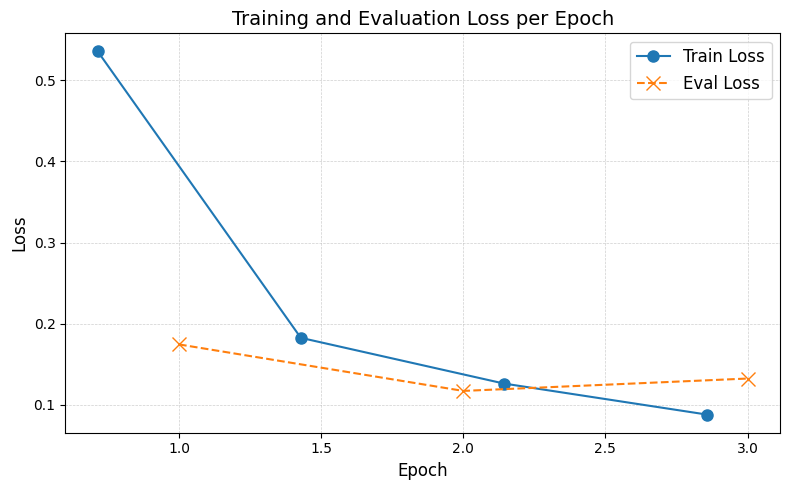

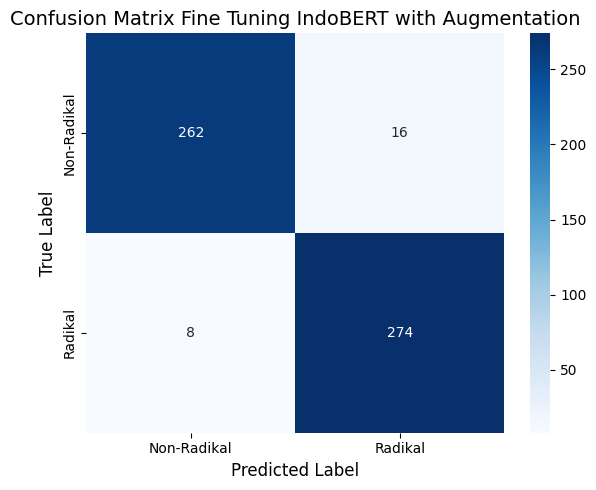

              precision    recall  f1-score   support

 Non-Radikal       0.97      0.94      0.96       278
     Radikal       0.94      0.97      0.96       282

    accuracy                           0.96       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.96      0.96      0.96       560



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch

# 1. Memuat dan mempersiapkan dataset
df = pd.read_csv('/content/drive/MyDrive/Word2vec/Dataset Labelled/Data Primer_Data Augmentasi_Word2vec_Cosine Similarity/data_postingan_labeled_augment.csv')
X = df['full_text'].tolist()
y_string_labels = df['label'].tolist()
label_map = {0: "Non-Radikal", 1: "Radikal"}
string_label_to_id = {v: k for k, v in label_map.items()}
y = [string_label_to_id[label] for label in y_string_labels]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = Dataset.from_dict({'full_text': X_train, 'label': y_train})
eval_dataset = Dataset.from_dict({'full_text': X_eval, 'label': y_eval})

# 2. Tokenisasi dataset
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["full_text"],
        # Remove padding=True here, padding will be handled by DataCollatorWithPadding
        truncation=True,
        max_length=512
    )

# Tokenisasi dataset sebelum training
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# 3. Memuat model IndoBERT
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

# 4. Mengatur TrainingArguments dengan EarlyStopping dan Learning Rate Scheduler
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/IndoBERT/results1",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=50,  # Log setiap 50 langkah
    eval_strategy="epoch",  # Evaluasi dilakukan setiap epoch
    save_strategy="epoch",  # Simpan model per epoch
    weight_decay=0.01,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# 5. Fungsi untuk menghitung metrik evaluasi
def compute_metrics(p):
    pred_ids = p.predictions.argmax(-1)  # Prediksi
    true_ids = p.label_ids  # Label sebenarnya
    target_names_for_report = [label_map[i] for i in sorted(label_map.keys())]

    report = classification_report(
        true_ids,
        pred_ids,
        output_dict=True,
        zero_division=0,
        labels=list(label_map.keys()),
        target_names=target_names_for_report
    )
    return {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

# Create a DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 6. Membuat Trainer dengan EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Early stopping
    data_collator=data_collator # Pass the data collator to the Trainer
)

# 7. Mulai pelatihan
trainer.train()

# 8. Menyimpan model yang sudah dilatih
trainer.save_model("/content/drive/MyDrive/IndoBERT/fine_tuned_indobert1")

# 9. Mengambil log dan visualisasi loss per epoch
logs = trainer.state.log_history

train_epoch_losses = {}
eval_epoch_losses = {}

for log in logs:
    epoch = log.get('epoch')
    if epoch is None:
        continue
    epoch_float = float(epoch)
    if 'loss' in log:
        if epoch_float not in train_epoch_losses:
            train_epoch_losses[epoch_float] = []
        train_epoch_losses[epoch_float].append(log['loss'])
    elif 'eval_loss' in log:
        eval_epoch_losses[epoch_float] = log['eval_loss']

train_epoch_avg_losses = {epoch: np.mean(losses) for epoch, losses in train_epoch_losses.items()}

plot_train_epochs = sorted(train_epoch_avg_losses.keys())
plot_train_losses = [train_epoch_avg_losses[e] for e in plot_train_epochs]
plot_eval_epochs = sorted(eval_epoch_losses.keys())
plot_eval_losses = [eval_epoch_losses[e] for e in plot_eval_epochs]

# Visualisasi loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(plot_train_epochs, plot_train_losses, label='Train Loss', marker='o', linestyle='-', markersize=8)
plt.plot(plot_eval_epochs, plot_eval_losses, label='Eval Loss', marker='x', linestyle='--', markersize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Evaluation Loss per Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# 10. Menampilkan classification report dan confusion matrix
predictions = trainer.predict(eval_dataset)
y_pred_ids = predictions.predictions.argmax(-1)  # Prediksi
y_true_ids = y_eval  # Label sebenarnya dari data evaluasi

# Confusion Matrix
cm = confusion_matrix(y_true_ids, y_pred_ids)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Non-Radikal", "Radikal"], yticklabels=["Non-Radikal", "Radikal"])
plt.title('Confusion Matrix Fine Tuning IndoBERT with Augmentation', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(
    y_true_ids,
    y_pred_ids,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    labels=list(label_map.keys())
))